# Модель DeepLabV3

In [1]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import albumentations as A
import numpy as np
from pathlib import Path
from PIL import Image
import os
from typing import Dict, Any
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import ModelCheckpoint
from typing import Dict, Any
import torchmetrics
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.loggers import TensorBoardLogger

c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.images = sorted(list(self.image_dir.glob("*.png"))) 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.mask_dir / img_path.name  # Маска с таким же именем

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))  # Маска в градациях серого
        mask = (mask > 0).astype(np.float32)  # Бинарная маска (0 или 1)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]
        
        if len(mask.shape) == 2:  # If mask is (256, 256), add channel dimension
            mask = mask[None, ...]  # Shape: (1, 256, 256)

        return image, mask

# Аугментация
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
])

In [3]:
train_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\train\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\train\masks',
    transform=train_transform
)

valid_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\val\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\val\masks',
    transform=val_transform
)

test_dataset = SegmentationDataset(
    image_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\test\images',
    mask_dir=r'D:\URFU\VKR\Ind_pract\dissert\data\test\masks',
    transform=val_transform
)

train_loader = DataLoader(train_dataset,
                                batch_size=4,
                                shuffle=True
                                )
valid_loader = DataLoader(valid_dataset,
                                batch_size=4
                                )
test_loader = DataLoader(test_dataset,
                                batch_size=4
                                )

images, masks = next(iter(train_loader))
print("Размерность изображений:", images.shape)
print("Размерность масок:", masks.shape)
print("Тип изображений:", images.dtype)
print("Тип масок:", masks.dtype)
print("Классы:", masks.unique())

Размерность изображений: torch.Size([4, 3, 256, 256])
Размерность масок: torch.Size([4, 1, 256, 256])
Тип изображений: torch.float32
Тип масок: torch.float32
Классы: tensor([0., 1.])


In [4]:
from pytorch_lightning.callbacks import Callback
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class PlotMetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.val_dices = []
        self.fig, (self.ax1) = plt.subplots(1, 1, figsize=(12, 5))
        self.display_handle = None

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss', None)
        val_loss = trainer.callback_metrics.get('val_loss', None)

        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        if val_loss is not None:
            self.val_losses.append(val_loss.item())

        # Clear previous plot output
        if self.display_handle is not None:
            clear_output(wait=True)

        # Clear axes
        self.ax1.clear()

        # Plot losses
        self.ax1.plot(self.train_losses, label='Train Loss', color='blue')
        self.ax1.plot(self.val_losses, label='Val Loss', color='orange')
        self.ax1.set_title('Loss over Epochs')
        self.ax1.set_xlabel('Epoch')
        self.ax1.set_ylabel('Loss')
        self.ax1.legend()
        self.ax1.grid(True)

        self.fig.tight_layout()
        
        # Display the updated plot
        self.display_handle = display(self.fig, display_id=True)

    def on_train_end(self, trainer, pl_module):
        # Ensure final plot remains visible
        if self.display_handle is not None:
            clear_output(wait=True)
            display(self.fig)
        plt.close(self.fig)  # Clean up

In [5]:
class DeepLabV3PlusLightning(pl.LightningModule):
    def __init__(self, encoder_name="resnet34", learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None, 
        )
        self.criterion = nn.BCEWithLogitsLoss()  # Лосс для бинарной сегментации
        self.lr = learning_rate
        self.iou = torchmetrics.JaccardIndex(task="binary", num_classes=2)  # IoU для бинарной сегментации

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.float())
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.float())
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.float())
        
        # Применяем сигмоиду и порог для получения бинарных предсказаний
        preds = torch.sigmoid(outputs) > 0.5
        
        # Вычисляем IoU
        iou_score = self.iou(preds, masks.int())
        
        # Вычисляем Dice вручную
        intersection = (preds & masks.int()).float().sum()
        union = preds.float().sum() + masks.float().sum()
        dice_score = (2.0 * intersection + 1e-8) / (union + 1e-8)  # Добавляем малое значение для избежания деления на 0
        
        # Логируем метрики
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_iou", iou_score, prog_bar=True)
        self.log("test_dice", dice_score, prog_bar=True)
        return {"test_loss": loss, "test_iou": iou_score, "test_dice": dice_score}

    def configure_optimizers(self) -> Dict[str, Any]:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\URFU\VKR\Ind_pract\dissert\data\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | DeepLabV3Plus      | 22.4 M | train
1 | criterion | BCEWithLogitsLoss  | 0      | train
2 | iou       | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
22.4 M    Trainable params
0         Non-trainable params
22.4 M    Total params
89.750    Total estimated model params size (MB)
174       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\ProgramData\anaconda3\envs\vkr\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1088/1088 [03:50<00:00,  4.73it/s, v_num=1, train_loss=0.181, val_loss=0.365]

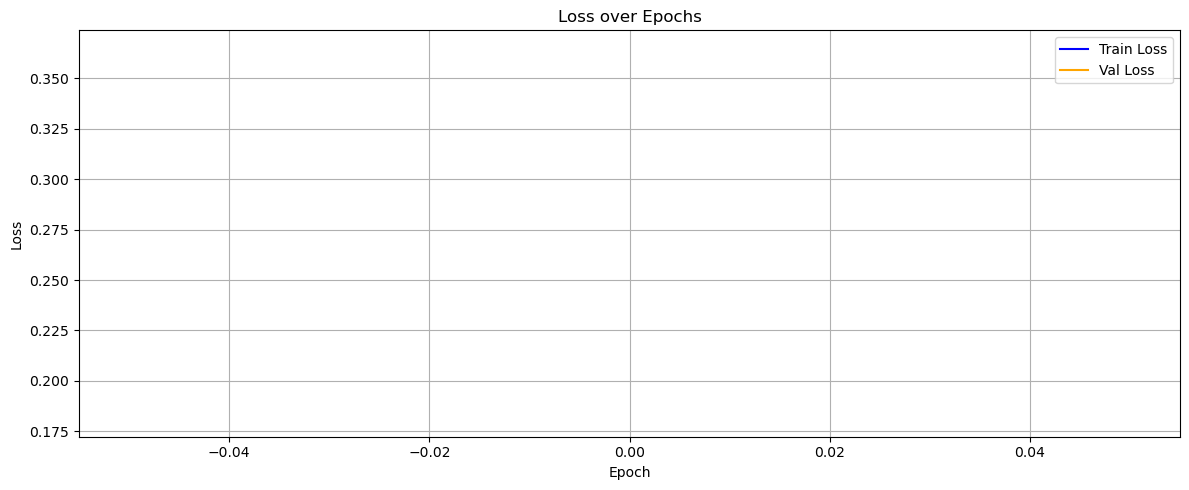

Epoch 1:  86%|████████▌ | 937/1088 [03:08<00:30,  4.97it/s, v_num=1, train_loss=0.276, val_loss=0.365] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

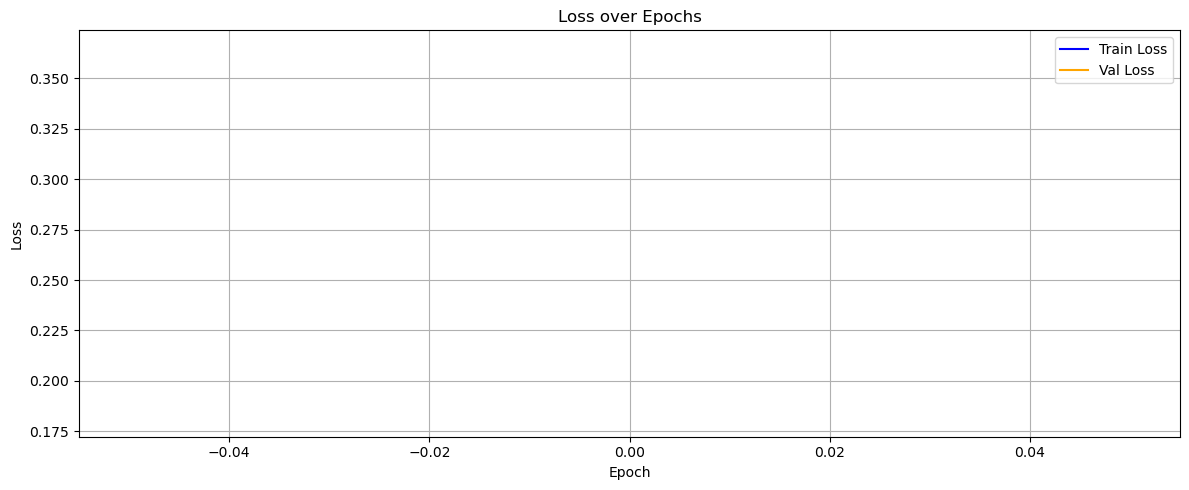

In [6]:
# Инициализация модели
model = DeepLabV3PlusLightning(encoder_name="resnet34", learning_rate=1e-3)


# Настройка логгера TensorBoard
logger = TensorBoardLogger(save_dir="../data/logs/", name="DeepLab_segmentation")

# Настройка callback для сохранения лучшей модели
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  
    dirpath="../data/checkpoints/", 
    filename="deeplab-{epoch:02d}-{val_loss:.2f}",  
    save_top_k=1, 
    mode="min"  
)

# Инициализация тренера
trainer = pl.Trainer(
    max_epochs=50,  # Количество эпох
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # Использовать GPU, если доступно
    devices=1,
    logger=logger,
    callbacks=[PlotMetricsCallback(), checkpoint_callback],
    log_every_n_steps=10,
)

# Обучение модели
trainer.fit(model, train_loader, valid_loader)




In [ ]:
# Тестирование модели
trainer.test(model, dataloaders=test_loader)

# Инференс

In [ ]:
# Загрузка модели из чекпоинта
model = DeepLabV3PlusLightning.load_from_checkpoint("deeplab_model.ckpt")
model.eval()

In [ ]:
import glob
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
import os
import numpy as np

# Путь к файлам
path = "/input_images"
files = glob.glob(path)
files = [file for file in files if os.path.isfile(file)]

class InferenceDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.transform = transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform(image)
        return image, self.image_paths[idx]  # Возвращаем также путь к файлу

# Создание DataLoader
test_dataset = InferenceDataset(files)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Инференс с использованием trainer
predictions = trainer.predict(model, dataloaders=test_loader)

# Визуализация предсказанных масок
plt.imshow(predictions[0], cmap="gray")  
plt.title("Segmentation Mask")
plt.axis("off")
plt.show()

# Создание директории для сохранения масок, если её нет
output_dir = "/output_masks"
os.makedirs(output_dir, exist_ok=True)

# Обработка предсказаний и сохранение масок
for batch, image_paths in zip(predictions, test_loader):
    pred = batch  # Предсказания для батча
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    pred = pred.squeeze().cpu().numpy()
    
    # Получаем путь к исходному изображению
    image_path = image_paths[1][0]  # Путь к файлу из датасета
    
    # Формируем имя выходного файла
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    output_path = os.path.join(output_dir, f"{base_name}_mask.png")
    
    # Сохранение предсказанной маски
    output_image = (pred * 255).astype(np.uint8)
    output_pil = Image.fromarray(output_image)
    output_pil.save(output_path)
    print(f"Saved mask: {output_path}")